# Seq2seq model with Attention mechanism - Machine Translation

### Tutorial Topics
- Seq2seq model with Attention mechanism

### Software Requirements
- Python (>=3.6)
- PyTorch (==1.9.0) 
- Jupyter (latest)
- torchtext (==0.5.0)
- NLTK

In [1]:
!pip install -U torch
!pip install torchtext==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Seq2seq model

![](https://drive.google.com/uc?id=1psT_kFqs0LowO5GFkjiAMDB-iOkpbXcT)

A seq2seq model has a encoder that consumes the source sentence (one token at a time) and a decoder that emits the target sentence (one token at a time). Although we used LSTM as our underlying encoder and decoder, the encoder/decoder can be a RNN, GRU, LSTM or [Transformer](https://arxiv.org/abs/1706.03762) (which we will see later in the course). In a standard seq2seq model, the hidden state of the decoder at the first timestep is initialized with the hidden state of the encoder at the last timestep (which we referred as **context** vector). Essentially, this context vector can summarize the information present in the source sentence, which is used by the decoder as a reference when it emits a target token.

Note that the figures in this tutorial are adapted from [CS224D](http://web.stanford.edu/class/cs224n/slides/cs224n-2020-lecture08-nmt.pdf).




## Seq2seq model with Attention mechanism

### Problem with traditional seq2seq

![](https://drive.google.com/uc?id=15PsbweisDlhmd9YNoyW4dWfvtAyB--Zl)

The fixed-length **context vector** carries the burden of encoding the complete "meaning" of the input sequence, regardless of its length. This causes **information bottleneck** problem. Attention provides a solution to the bottleneck problem.

### Attention mechanism (Informal)
*Core idea of attention:* On each step of the decoder, we use **direct connection to the encoder** to **focus on a particular part** of the source sequence.

We perform a dot product of the current decoder hidden state with each encoder hidden state. And the resulting scores are called as **attention scores**.

![](https://drive.google.com/uc?id=1qQGZKd6k-FwAE86q0W9DTNTD9xpQgt7W)

![](https://drive.google.com/uc?id=1okSgLpyo4yZFbIJ05k86fhjET7mrU3Ng)

These attention scores are unnormalized and hence need to be converted to a probability distribution using softmax to get **attention distribution**.

![](https://drive.google.com/uc?id=1FhS88tXfOGep8gYjg7mK0QYTYRSBH0mw)

In the attention distribution, the attention probabilities corresponding to the source tokens will be high for the tokens that the decoder at a given timestep wants to focus on. In our example, the decoder at the first timestep after consuming the `start` token focusses more on the source token `j'aime` to output the target token `I`.

![](https://drive.google.com/uc?id=19Eu6e-PSPHArsMeuVIwgbYPuTbwsNfU1)

We use the probabilities from the attention distribution to perform a weighted sum of the encoder hidden states. This weighted sum is called as **attention output** or **context vector**. This attention output mostly contains information from the hidden states that received high attention.

![](https://drive.google.com/uc?id=1Aiq9dL9Pom2rJNTwzukIApB6YsPGxJmy)

We concatenate the **attention output** (**context vector**) with the current decoder input embedding, feed it to the RNN and predict the target token (`I` for the first timestep of the decoder).

![](https://drive.google.com/uc?id=1FzcRoBccsDKQfAC4PmWx5gzqXYEImwQ-)

And we repeat these steps (computing attention scores, attention distribution, attention outputs, concatenation with the current decoder input embedding) on each timestep of the decoder.

![](https://drive.google.com/uc?id=1pdtYVb4aHZ6kY310biggab3Ig0oj7Si9)


### Attention mechanism (Formal)

Let us formalize some of the concepts underlying attention mechanism. 

* We have encoder hidden states, $h_1,\dots,h_j,\dots,h_T \in \mathbb{R}^h$
* On timestep $t$, we have decoder hidden state, $s_t \in \mathbb{R}^h$  (where $s_0 = h_T$)
* We have the attention score for a decoder hidden state and an encoder hidden state, $e_{ij} = a(s_{i-1}, h_j) = s_{i-1}^Th_j \in \mathbb{R}$
* We can get the attention score vector for a decoder hidden state, $e_{i} = [e_{i1},\dots,e_{ij},\dots,e_{iT}] \in \mathbb{R}^T$ 
* We take softmax of the attention score vector to get the attention distribution, $\alpha_{i} = softmax(e_{i}) \in \mathbb{R}^T$ 
* We use $\alpha_{i}$ to take a weighted sum of the encoder hidden states to get the attention output or context vector, $c_{i} = \sum_{j=1}^T \alpha_{ij} h_j  \in \mathbb{R}^h$

![](https://drive.google.com/uc?id=1uCfSNcIFazs1s_tFT6j5tfwgo2k5mir4)

### Different ways to compute attention scores

For a given decoder hidden state $s_{i-1}$ and encoder hidden state $h_j$, we compute attention score, $e_{ij} = s_{i-1}^Th_j \in \mathbb{R}$. This way of using dot product to compute attention was introduced by [Luong et al. 2015](https://arxiv.org/abs/1508.04025) and referred in the literature as **Dot-Product/multiplicative** attention. 

However, the first paper which introduced attention mechanism was [Bahdanau et al. 2015](https://arxiv.org/abs/1409.0473). They compute the attention score in the following way, $e_{ij} = v_a tanh (W_a [s_{i-1};h_j;]) \in \mathbb{R}$ where $W_a \in \mathbb{R}^{h\times 2h}$ and $v_a \in \mathbb{R}^{1\times h}$. We will be using **Bahdanau's concatenative/additive attention** in this tutorial. (Note: Bahdanau's is referred to as "concatenative/additive" to distinguish it from Luong's Dot-Product/multiplicative attention. You will see later that, for Bahdanau, we concatenate the attention output (context vector) with the current decoder input embedding).

In this tutorial, we will implement the seq2seq model with attention mechanism for French to English translation task.

The following sections include:
* Preparing Data
* Encoder (1 or few lines different)
* Training the Seq2Seq Model
* Testing Model (1 or few lines different)


### Required libraries

In [3]:
import unicodedata
import string
import re
import random
import time
import datetime
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torchtext
from torchtext import data

from nltk.tokenize import word_tokenize
import numpy as np

### Preparing Data

***Define tokenizers:***
we create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string.


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [5]:
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings (tokens)
    """
    return word_tokenize(text, language='french')

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return word_tokenize(text, language='english')

`TorchText`'s Fields handle how data should be processed. You can read all of the possible arguments [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61).

We set the tokenize argument to the corresponding tokenization function for each, with French being the `SRC` (source) field and English being the `TRG` (target) field. The field also appends the "start of sequence" (\<sos\>) and "end of sequence" (\<eos\>) tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

In [6]:
SRC = data.Field(tokenize = tokenize_fr, 
            # init_token = '<sos>', # since initial encoder hidden state is always set to zero, the network can figure out that the time step is 0 and this token is optional
            eos_token = '<eos>', 
            lower = True)
TRG = data.Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Next, we load the train, validation and test data.

The dataset we'll be using is the [Multi30k](https://github.com/multi30k/dataset) dataset. This is a dataset with ~30,000 parallel English, French and German sentences. The length of sentence is around 12 words. You can find more information in [WMT18](http://www.statmt.org/wmt18/multimodal-task.html). This corpus was officially split to Training (29,000 sentences), Validation (1,014 sentences), and multiple Test sets. We provide Test 2016 (1,000 sentences). 

I extracted the raw dataset to three `.tsv` files. Each file includes two column, 'English' and 'French'. We use `torchtext.legacy.data.TabularDataset` to load these tsv files. 

In [7]:
train, val, test = data.TabularDataset.splits(
    path='./drive/MyDrive/Colab Notebooks/eng-fre/', train='train_eng_fre.tsv',validation='val_eng_fre.tsv', test='test_eng_fre.tsv', 
    format='tsv', skip_header=True, fields=[('TRG', TRG), ('SRC', SRC)])

We can double check that we've loaded the right number of examples:

In [8]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of validation examples: {len(val.examples)}")
print(f"Number of testing examples: {len(test.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


We can also print out an example:

In [9]:
print(vars(train.examples[0]))

{'TRG': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.'], 'SRC': ['deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.']}


In [10]:
print(vars(val.examples[100]))

{'TRG': ['an', 'older', ',', 'overweight', 'man', 'flips', 'a', 'pancake', 'while', 'making', 'breakfast', '.'], 'SRC': ['un', 'homme', 'âgé', 'en', 'surpoids', 'fait', 'sauter', 'une', 'crêpe', 'en', 'préparant', 'le', 'petit', 'déjeuner', '.']}


Next, we'll build the vocabulary for the source and target languages. 

The vocabulary is used to associate each unique token with an index and this is used to build a one-hot encoding for each token. The vocabularies of the source and target languages are minimal overlap.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

It is important to note that your vocabulary should only be built from the `training set` and not the `validation/test set`. This prevents **"information leakage"** into your model, giving you artifically inflated validation/test scores.

In [11]:
TRG.build_vocab(train,min_freq=2)
SRC.build_vocab(train,min_freq=2)

In [12]:
print(f"Unique tokens in source (fr) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (fr) vocabulary: 6707
Unique tokens in target (en) vocabulary: 5920


`TRG.vocab.stoi` is the dictionary of word to index. For example, the index of `<pad>` is 1.

In [13]:
print(TRG.vocab.stoi['<pad>'])

1


The final step of preparing the data is to create the `iterators` to generate batches. These can be iterated on to return a batch of data. The text of both source and target text will be converted to two sequence of corresponding indexes, using the vocabularies.


We also need to define a `torch.device`. This indicate whether the input `tensors` should be sent to `GPU` or not. We already defined the `device` variable before. 

Finally, the output of the iterator will be `padded`. 

We use a `BucketIterator` to creates batches.

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), # we pass in the datasets we want the iterator to draw data from
    batch_sizes=(16, 256, 256),device = device,
    sort_key=lambda x: len(x.SRC), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False)

Each batch will include two tensors: tensor of source language and tensor of target language. The size of each tensor is **[max_length, batch_size]**. Each example is already padded within batch.

In [16]:
# batch example of training data
for batch in train_iter:
    src = batch.SRC
    trg = batch.TRG
    print('tensor size of source language:', src.shape)
    print('tensor size of target language:', trg.shape)
    print('the tensor of first example in target language:', trg[:,0])
    break

tensor size of source language: torch.Size([21, 16])
tensor size of target language: torch.Size([20, 16])
the tensor of first example in target language: tensor([   2,    4,   23,   34,   10,  408,   21,  385,  157,    6,    4, 1063,
           5,    3,    1,    1,    1,    1,    1,    1], device='cuda:0')


We save our Fields for reproducibility.

In [17]:
import pickle
with open("./drive/MyDrive/Colab Notebooks/ckpt_attn/TRG.Field","wb")as f:
     pickle.dump(TRG,f)

with open("./drive/MyDrive/Colab Notebooks/ckpt_attn/SRC.Field","wb")as f:
     pickle.dump(SRC,f)

## Building the Seq2seq Model with Attention mechanism

## 2. Encoder

First, we'll build the encoder. We use a single layer `Uni-directional LSTM`.

As classifiction task, we only pass the output of embedding layer to the LSTM layer. The LSTM layer returns `outputs`, `hidden` and `cell`. The `hidden` is the final hidden state of LSTM layer. The `cell` is the final cell state of LSTM layer. `hidden` and `cell` can be considered as the **context** representation of source language. 

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dropout = dropout
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, enc_hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.lstm(embedded)
       
        # outputs are always from the top hidden layer, if bidirectional outputs are concatenated.
        # outputs shape [sequence_length, batch_size, hidden_dim * num_directions]
        # hidden is of shape [num_layers * num_directions, batch_size, hidden_size]
        # cell is of shape [num_layers * num_directions, batch_size, hidden_size]
        
        return outputs, (hidden.squeeze(0), cell)

## 3. Attention

We will implement the attention layer now. As discussed before, we will be using **Luong's concat attention** to compute the attention score, $e_{ij} = v_a tanh (W_a [s_{i-1};h_j;]) \in \mathbb{R}$ where $W_a \in \mathbb{R}^{h\times 2h}$ and $v_a \in \mathbb{R}^{1\times h}$. 

In the following example, we will illustrate how we compute $e_{11}$.

![](https://drive.google.com/uc?id=10JarMXg_ZBSvKLfUW-LQ82XmBeJOlFhR)

Using the same attention score function, we compute $e_{12}$ as follows:

![](https://drive.google.com/uc?id=1lodBDLu_D_jxeZOoOnd_qhNa-HlSFmcq)

We continue the process for the remaining encoder hidden states and obtain $e_{13}$, $e_{14}$ and $e_{15}$. Essentially, we have created $e_i$ by iterating over each encoder hidden state.

![](https://drive.google.com/uc?id=1NMErg15nGgd8RRlhTkfF2B2W6Y1f1pwF)

Instead of iterating over each encoder hidden state, we will create $e_i$ in one pass. We stack up all the encoder hidden states to get $H \in \mathbb{R}^{T\times h}$ (in our example, T is 5). We repeat the current decoder hidden state $T-1$ times to get a matrix ( $\mathbb{R}^{T\times h}$) and concate this matrix with $H$ (to get $\mathbb{R}^{T\times 2h})$. We feed this to the attention scoring function as shown below:

![](https://drive.google.com/uc?id=1L7Coxz6mXCSniNGA7vf7UZdB-1TxP0aR)

Once we get the attention scores, we convert the scores to attention probabilites using softmax, $\alpha_{i} = softmax(e_{i}) \in \mathbb{R}^T$.
![](https://drive.google.com/uc?id=1vJLUfIkpfvjr5JGy-_lS_54F7wo_1af0)


In [19]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.W_a = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim)
        self.v_a = nn.Parameter(torch.rand(dec_hid_dim)) # same as doing nn.Linear(dec_hid_dim, 1, bias=False)
        self.neg_inf = torch.tensor(-1e7, device=device)
        
    def forward(self, hidden, encoder_outputs, attention_mask):
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim]
        #attention_mask = [batch_size, src_len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len-1 times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim]
        
        # attention scoring function - part 1 - tanh(W_a[s;h])
        energy = torch.tanh(self.W_a(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]
        
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src len]
        
        #v = [dec hid dim]
        
        v = self.v_a.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
        
        # attention scoring function - part 2 - v_a(tanh(W_a[s;h]))
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention= [batch size, src len]

        # before computing the softmax, set attention to pad tokens to -infinity
        attention[attention_mask] = self.neg_inf

        # attention scoring function - part 2 - softmax(v_a(tanh(W_a[s;h])))
        return F.softmax(attention, dim=1)

### 4. Decoder

We will implement the decoder now. We get the attention probabilities ($\alpha_{i}$) as the output from the attention layer. We use $\alpha_{i}$ to take a weighted sum of the encoder hidden states to get the attention output or context vector, $c_{i} = \sum_{j=1}^T \alpha_{ij} h_j $. We concatenate $c_i$ with the current decoder input embedding and proceed as in the non-attention seq2seq model. We will illustrate these two steps for our example.

![](https://drive.google.com/uc?id=1scvvOneIAFk5Sob1SdghccJBy8qq9ePU)


In [20]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(enc_hid_dim + emb_dim, dec_hid_dim, n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(enc_hid_dim + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell, encoder_outputs, attention_mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim]
        #attention_mask = [batch_size, src_len]
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        # get the attention probabilities
        attention_weights = self.attention(hidden, encoder_outputs, attention_mask)
                
        #attention_weights = [batch size, src len]
        
        attention_weights = attention_weights.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim]
        # perform weighted sum of encoder hidden states to get attention output
        weighted = torch.bmm(attention_weights, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim]
        # concatenate the attention outputs (or context vectors) with the current decoder input
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim) + emb dim]
        output, (hidden, cell) = self.rnn(rnn_input, (hidden.unsqueeze(0), cell))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        # classification over the entire word vocabulary
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), cell, attention_weights

### 5. Seq2seq with attention

The `encoder` returns both the final hidden state ($h_T$) to be used as the initial hidden state for the decoder ($s_0$) and the encoder outputs ($H$) in stacked form. We pass the `hidden` and `encoder_outputs` to the decoder. 

We will go over the steps briefly:
- the `outputs` tensor is created to hold all predictions, $\hat{Y} = \{\hat{y_1} ... \hat{y_t}\}$;
- the source sequence, $X = \{x_1,..., x_T\}$, is fed into the encoder to receive $h_T$ and $H$
- the initial decoder hidden state is set to be the last hidden state of the encoder, $s_0 = h_T$ (note we all set the initial cell states of the decoder with the last cell states of the encoder)
- we use a batch of `<sos>` tokens as the first `input`, $y_0$
- we then decode within a loop:

for i in range(1,t): t is the maximal length of target language
  - inserting the input token $y_i$, previous hidden state, $s_{i-1}$, and previous cell state, $c_{i-1}$, into the decoder;
  - receiving a prediction, $\hat{y}_{i+1}$, which is the most likely output token, a new hidden state, $s_{i}$, and a new cell state, $c_{i}$;
  - we then decide if we are going to perform **teacher forcing** or not, setting the next input as appropriate.

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # create attention mask, set attention to pad tokens to -infinity 
        attention_mask = (src == SRC.vocab.stoi[SRC.pad_token]).transpose(0, 1)
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        # save the encoder-decoder attention weights
        # all_attention_weights = [batch_size, trg len-1, src len ]
        all_attention_weights = torch.zeros(trg.shape[1], trg.shape[0]-1, src.shape[0])
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, (hidden, cell) = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, cell, attention_weights = self.decoder(input, hidden, cell, encoder_outputs, attention_mask)
            
            # all_attention_weights[t-1] = [src len, batch size]
            all_attention_weights[:,t-1,:] = attention_weights.squeeze(1)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs,all_attention_weights

## 6. Training the Seq2Seq Model

We instantiate our encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

# hyperparameters
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_LAYERS = 1
LEARNING_RT = 0.001

# model components
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


We use a simplified version of the weight initialization scheme. Here, we will initialize all biases to zero and all weights from $\mathbb{N}(0, 0.01)$.

In [23]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6707, 256)
    (lstm): LSTM(256, 512, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (W_a): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(5920, 256)
    (rnn): LSTM(768, 512, dropout=0.5)
    (fc_out): Linear(in_features=1280, out_features=5920, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

**Calculate the number of parameters.**

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,543,840 trainable parameters


Create an optimizer.

In [25]:
optimizer = optim.Adam(model.parameters())

Initialize the loss function. The pad token will be ignored.

In [26]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
print('<pad> token index: ',TRG_PAD_IDX)
## we will ignore the pad token in true target set
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

<pad> token index:  1


### 7. Testing Model
We will run the model with first training batch to test our code.

In [27]:
clip = 1
model.train()

for i, batch in enumerate(train_iter):

    src = batch.SRC
    trg = batch.TRG
    optimizer.zero_grad()
    output,_ = model(src, trg)
    #trg = [trg len, batch size]
    #output = [trg len, batch size, output dim]

    output_dim = output.shape[-1]

    output = output[1:].view(-1, output_dim)
    trg = trg[1:].view(-1)

    #trg = [(trg len - 1) * batch size]
    #output = [(trg len - 1) * batch size, output dim]

    loss = criterion(output, trg)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()

    print(loss/src.shape[1])
    break

tensor(0.5429, device='cuda:0', grad_fn=<DivBackward0>)


## 8. Full training process
We also offer the fully training loop as follows:

In [28]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.SRC
        trg = batch.TRG
        
        optimizer.zero_grad()
        
        output,_ = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing (i.e., teach forcing rate = 0).

In [29]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.SRC
            trg = batch.TRG

            output,_ = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Count the running time.

In [30]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Training model. 

We will train the model for 10 epochs. At the end of each epoch, we will save a checkpoint and evaluate on the development set. We will print out the loss and perplexity of train and dev set.

In [31]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_iter, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Create checkpoint at end of each epoch
    state_dict_model = model.state_dict() 
    state = {
        'epoch': epoch,
        'state_dict': state_dict_model,
        'optimizer': optimizer.state_dict()
        }

    torch.save(state, "./drive/MyDrive/Colab Notebooks/ckpt_attn/seq2seq_"+str(epoch+1)+".pt")

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 2m 41s
	Train Loss: 4.214 | Train PPL:  67.598
	 Val. Loss: 3.818 |  Val. PPL:  45.505
Epoch: 02 | Time: 2m 34s
	Train Loss: 2.783 | Train PPL:  16.171
	 Val. Loss: 3.130 |  Val. PPL:  22.883
Epoch: 03 | Time: 2m 34s
	Train Loss: 2.135 | Train PPL:   8.455
	 Val. Loss: 2.958 |  Val. PPL:  19.263
Epoch: 04 | Time: 2m 33s
	Train Loss: 1.767 | Train PPL:   5.852
	 Val. Loss: 2.860 |  Val. PPL:  17.460
Epoch: 05 | Time: 2m 40s
	Train Loss: 1.514 | Train PPL:   4.545
	 Val. Loss: 2.887 |  Val. PPL:  17.943
Epoch: 06 | Time: 2m 34s
	Train Loss: 1.321 | Train PPL:   3.746
	 Val. Loss: 2.881 |  Val. PPL:  17.838
Epoch: 07 | Time: 2m 33s
	Train Loss: 1.159 | Train PPL:   3.186
	 Val. Loss: 2.916 |  Val. PPL:  18.460
Epoch: 08 | Time: 2m 34s
	Train Loss: 1.042 | Train PPL:   2.834
	 Val. Loss: 2.999 |  Val. PPL:  20.061
Epoch: 09 | Time: 2m 32s
	Train Loss: 0.951 | Train PPL:   2.588
	 Val. Loss: 3.103 |  Val. PPL:  22.271
Epoch: 10 | Time: 2m 32s
	Train Loss: 0.870 | Train PPL

## 9. Load Checkpoint
We will use the best model for the following process.

Load the saved TRG and SRC fields:

In [32]:
with open("./drive/MyDrive/Colab Notebooks/ckpt_attn/TRG.Field","rb") as f:
     TRG_saved = pickle.load(f)

with open("./drive/MyDrive/Colab Notebooks/ckpt_attn/SRC.Field","rb") as f:
     SRC_saved = pickle.load(f)

Load trained model to `model_best` and put model on device.

In [33]:
INPUT_DIM = len(SRC_saved.vocab)
OUTPUT_DIM = len(TRG_saved.vocab)

# hyperparameters
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
N_LAYERS = 1
LEARNING_RT = 0.001

# model components
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
model_best = Seq2Seq(enc, dec, device)

In [34]:
model_best.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/ckpt_attn/seq2seq_6.pt')['state_dict'])
model_best = model_best.to(device)

Pre-process source language and get input tensor

In [35]:
model_best.eval()
src_token = SRC_saved.preprocess('Une femme avec un gros sac passe par une porte.')
print("src_token:", src_token)
src_tensor = SRC_saved.process([src_token],device=device)
print("shape of source language: ", src_tensor.shape)

src_token: ['une', 'femme', 'avec', 'un', 'gros', 'sac', 'passe', 'par', 'une', 'porte', '.']
shape of source language:  torch.Size([12, 1])


We assume this is a test sample so we don't have the gold target text. We create a placeholder for target language which only includes 64 `<pad>` tokens (i.e., the maximal length of our translated generation is 64).

In [36]:
trg_token = ['<pad>']*64
trg_tensor = TRG_saved.process([trg_token],device=device)
print("shape of target language: ", trg_tensor.shape)

shape of target language:  torch.Size([66, 1])


In [37]:
output, all_attention_weights = model_best(src_tensor, trg_tensor, teacher_forcing_ratio = 0.0)
output_dim = output.shape[-1]
# get translation results, we ignore first token <sos> in both translation and target sentences. 
# output_translate = [(trg len - 1), batch, output dim] output dim is size of target vocabulary. 
output_translate = output[1:]

Detach the source input tensor to CPU device because our following process will operate on CPU. Then, squeeze the shape of `output_translate` to `[(trg len - 1),output dim]`. 

In [38]:
source_language = src_tensor[:,0].cpu().numpy()
translation_logit = output_translate[:,0,:].squeeze(1)

In [39]:
# Choose top 1 word from decoder's output, we get the probability and index of the word
prob, token_id = translation_logit.data.topk(1)
token_id = token_id.squeeze(1).cpu().numpy()
print(token_id) 

[  4  14  13   4  58 640  10  41  48   4 761   5   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3]


To get the translation in text, we will use a dictionary to convert index to word.


In [40]:
# get source langauge in text
src_language = []

for i in source_language:
    if i == SRC.vocab.stoi['<eos>']:
        break
    else:
        token = SRC.vocab.itos[i]
        src_language.append(token)
print("Source language:", src_language)

# get machine translation in text
trans_language = []
for i in token_id:
    if i == TRG.vocab.stoi['<eos>']:
        break
    else:
        token = TRG.vocab.itos[i]
        trans_language.append(token)
print("Our model translation: ", trans_language)
print("Golden translation: ", "a woman with a large purse is walking by a gate.")

Source language: ['une', 'femme', 'avec', 'un', 'gros', 'sac', 'passe', 'par', 'une', 'porte', '.']
Our model translation:  ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'doorway', '.']
Golden translation:  a woman with a large purse is walking by a gate.


### 10. Visualization

Attention provides some interpretability. We can inspect the attention distribution values ($\alpha_t \in \mathbb{R}^T$) at each decoding timestep to see where the decoder was focusing on.

In [41]:
source_language = src_tensor[:,0].cpu().numpy()
translation_logit = output_translate[:,0,:].squeeze(1)
weights = all_attention_weights[0,:,:].squeeze(1).cpu().detach().numpy()

When we choose top 1 word from decoder's output, we get the probability and index of the word

In [42]:
prob, token_id = translation_logit.data.topk(1)
token_id = token_id.squeeze(1).cpu().numpy()
print(token_id)

[  4  14  13   4  58 640  10  41  48   4 761   5   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3]


We will get the source language in textual form (from word ids).

In [43]:
src_language = []

for i in source_language:
    if i == SRC.vocab.stoi['<eos>']:
        break
    else:
        token = SRC.vocab.itos[i]
        src_language.append(token)
print("Source language:", src_language)

Source language: ['une', 'femme', 'avec', 'un', 'gros', 'sac', 'passe', 'par', 'une', 'porte', '.']


We will get the machine translation in textual form (from word ids)

In [44]:
trans_language = []
for i in token_id:
    if i == TRG.vocab.stoi['<eos>']:
        break
    else:
        token = TRG.vocab.itos[i]
        trans_language.append(token)
print("Our model translation: ", trans_language)
print("Golden translation: ", "a woman with a large purse is walking by a gate.")

Our model translation:  ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'doorway', '.']
Golden translation:  a woman with a large purse is walking by a gate.


We can now use matplotlib machinery to plot the attention weights.

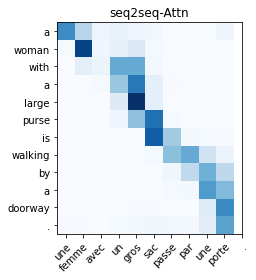

In [53]:
import matplotlib
import matplotlib.pyplot as plt

weights = np.array(weights)[0:len(trans_language), 0:len(src_language)]

fig, ax = plt.subplots()
im = ax.imshow(weights,cmap=plt.cm.Blues)
# plt.colorbar(im)
# We want to show all ticks...
ax.set_xticks(np.arange(len(src_language)))
ax.set_yticks(np.arange(len(trans_language)))
# ... and label them with the respective list entries
ax.set_xticklabels(src_language)
ax.set_yticklabels(trans_language)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("seq2seq-Attn")
fig.tight_layout()
plt.show()

### 11. Evaluation of the model using BLEU

We will evaluate the trained model using BLEU-4 metric (the same metric we implemented in the last tutorial). 

In [47]:
def inference(model, file_name, src_vocab, trg_vocab, attention = True, max_trg_len = 64):
    '''
    Function for translation inference

    Input: 
    model: translation model;
    file_name: the directoy of test file that the first column is target reference, and the second column is source language;
    trg_vocab: Target torchtext Field
    attention: the model returns attention weights or not.
    max_trg_len: the maximal length of translation text (optinal), default = 64

    Output:
    Corpus BLEU score.
    '''
    from nltk.translate.bleu_score import corpus_bleu
    from nltk.translate.bleu_score import sentence_bleu
    from torchtext.data import TabularDataset
    from torchtext.data import Iterator

    # convert index to text string
    def convert_itos(convert_vocab, token_ids):
        list_string = []
        for i in token_ids:
            if i == convert_vocab.vocab.stoi['<eos>']:
                break
            else:
                token = convert_vocab.vocab.itos[i]
                list_string.append(token)
        return list_string

    test = TabularDataset(
      path=file_name, # the root directory where the data lies
      format='tsv',
      skip_header=True, # if your tsv file has a header, make sure to pass this to ensure it doesn't get proceesed as data!
      fields=[('TRG', trg_vocab), ('SRC', src_vocab)])

    test_iter = Iterator(
    dataset = test, # we pass in the datasets we want the iterator to draw data from
    sort = False,batch_size=128,
    sort_key=None,
    shuffle=False,
    sort_within_batch=False,
    device = device,
    train=False
    )
  
    model.eval()
    all_trg = []
    all_translated_trg = []

    TRG_PAD_IDX = trg_vocab.vocab.stoi[trg_vocab.pad_token]

    with torch.no_grad():
    
        for i, batch in enumerate(test_iter):

            src = batch.SRC
            #src = [src len, batch size]

            trg = batch.TRG
            #trg = [trg len, batch size]

            batch_size = trg.shape[1]

            # create a placeholder for traget language with shape of [max_trg_len, batch_size] where all the elements are the index of <pad>. Then send to device
            trg_placeholder = torch.Tensor(max_trg_len, batch_size)
            trg_placeholder.fill_(TRG_PAD_IDX)
            trg_placeholder = trg_placeholder.long().to(device)
            if attention == True:
              output,_ = model(src, trg_placeholder, 0) #turn off teacher forcing
            else:
              output,_ = model(src, trg_placeholder, 0) #turn off teacher forcing
            # get translation results, we ignor first token <sos> in both translation and target sentences. 
            # output_translate = [(trg len - 1), batch, output dim] output dim is size of target vocabulary.
            output_translate = output[1:]
            # store gold target sentences to a list 
            all_trg.append(trg[1:].cpu())

            # Choose top 1 word from decoder's output, we get the probability and index of the word
            prob, token_id = output_translate.data.topk(1)
            translation_token_id = token_id.squeeze(2).cpu()

            # store gold target sentences to a list 
            all_translated_trg.append(translation_token_id)
      
    all_gold_text = []
    all_translated_text = []
    for i in range(len(all_trg)): 
        cur_gold = all_trg[i]
        cur_translation = all_translated_trg[i]
        for j in range(cur_gold.shape[1]):
            gold_convered_strings = convert_itos(trg_vocab,cur_gold[:,j])
            trans_convered_strings = convert_itos(trg_vocab,cur_translation[:,j])

            all_gold_text.append(gold_convered_strings)
            all_translated_text.append(trans_convered_strings)

    corpus_all_gold_text = [[item] for item in all_gold_text]
    corpus_bleu_score = corpus_bleu(corpus_all_gold_text, all_translated_text)  
    return corpus_bleu_score

#using example 
bleu_score = inference(model_best, "./drive/MyDrive/Colab Notebooks/eng-fre/test_eng_fre.tsv", SRC_saved, TRG_saved, True, 64)
print('BLEU score of the best model is %.3f'%bleu_score)

BLEU score of the best model is 0.437


### 12. Evaluation Metrics

#### Evaluation with perplexity

[Perplexity](https://en.wikipedia.org/wiki/Perplexity) is an information theoretic measurement of how well probability model predicts a sample. Low perplexity values indicate a better fit.

In language modeling, we build a language generation system with state distribution `q` which tries to mimic the real-world language with the state distribution `p` as much as possible. However, in practice we do not know the exact `p`, we only know $\tilde{p}$  which is a sampled distribution (i.e., our dataset) from the real-world system. We use a perplexity with cross entropy $PPL( \tilde{p} ,q)$. Perplexity is defined as: 

$PPL( \tilde{p} ,q) = e^{Entropy[\tilde{p},q]}$

where $Entropy[\tilde{p},q]$ is the `CrossEntropy` loss of our translation model, q is our translation system.
We can directly use `math.exp(train_loss)` get the perplexity of our model. 

#### Evaluation with BLEU score

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

NLTK provides the [sentence_bleu()](http://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.sentence_bleu) function for evaluating a candidate sentence against one or more reference sentences.

In [48]:
from nltk.translate.bleu_score import sentence_bleu

 Let's take a look at a simple example:

In [49]:
# two references for one document
from nltk.translate.bleu_score import corpus_bleu
references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
candidates = [['this', 'is', 'a', 'test']]
score = corpus_bleu(references, candidates)
print("BLEU score:",score)

BLEU score: 1.0


By default, the sentence_bleu() and corpus_bleu() scores calculate the cumulative 4-gram BLEU score, also called **BLEU-4**. The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores. 

In [50]:
# now, use BLEU evaluate our translation

# tokenize our golden sentence
tokens = TRG.preprocess("a woman with a large purse is walking by a gate.")
print("tokens:\t", tokens)
references = [[tokens]]
print("Our model translation:\t", trans_language)
our_translation = [trans_language]

score = corpus_bleu(references, our_translation) # same as corpus_bleu(reference, our_translation, weights=(0.25, 0.25, 0.25, 0.25))
print("BLEU score:",score)

tokens:	 ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']
Our model translation:	 ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'doorway', '.']
BLEU score: 0.8265168183793802


The cumulative and individual 1-gram BLEU use the same weights, e.g. (1, 0, 0, 0). The 2-gram weights assign a 50% to each of 1-gram and 2-gram and the 3-gram weights are 33% for each of the 1, 2 and 3-gram scores.

Let’s make this concrete by calculating the cumulative scores for BLEU-1, BLEU-2, BLEU-3 and BLEU-4:

In [51]:
# cumulative BLEU scores
print('Cumulative 1-gram: %f' % corpus_bleu(references, our_translation, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % corpus_bleu(references, our_translation, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % corpus_bleu(references, our_translation, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % corpus_bleu(references, our_translation, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.916667
Cumulative 2-gram: 0.866025
Cumulative 3-gram: 0.844870
Cumulative 4-gram: 0.826517


## Reference 
* https://pytorch.org/docs/stable/nn.html
* https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb
* https://arxiv.org/abs/1409.3215
* https://github.com/graviraja/seq2seq
* https://github.com/eladhoffer/seq2seq.pytorch
* https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation
* http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
* http://web.stanford.edu/class/cs224n/slides/cs224n-2020-lecture08-nmt.pdf
* https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
* https://leimao.github.io/blog/Entropy-Perplexity/